# Anomaly detection using a global normalization

In [1]:
using CABLAB

In this example we combine the subsample-quantile approach with the extreme event detection methods. We first take some sample grid cells out of the cube, calculate the 40% and 60% quantile to normalize the variables against each other. We also use this subsample to train the optimization paramters used for the extreme event detectioon methods. 

In [2]:
c=Cube("/Net/Groups/BGI/scratch/DataCube/v0.2.0/low-res")

CABLAB data cube at /Net/Groups/BGI/scratch/DataCube/v0.2.0/low-res
Spatial resolution:  1440x720 at 0.25 degrees.
Temporal resolution: 2001-01-01T00:00:00 to 2012-01-01T00:00:00 at 8daily time steps
Variables:           Rg aerosol_optical_thickness_1610 aerosol_optical_thickness_550 aerosol_optical_thickness_555 aerosol_optical_thickness_659 aerosol_optical_thickness_865 air_temperature_2m bare_soil_evaporation black_sky_albedo burnt_area c_emissions country_mask evaporation evaporative_stress fpar_fluxcom fractional_snow_cover gross_primary_productivity interception_loss land_surface_temperature latent_energy net_ecosystem_exchange open_water_evaporation ozone potential_evaporation precipitation root_moisture sensible_heat snow_sublimation snow_water_equivalent soil_moisture surface_moisture terrestrial_ecosystem_respiration transpiration water_mask water_vapour white_sky_albedo 


In [3]:
cdata=getCubeData(c,variable=c.dataset_files,longitude=(-10,35),latitude=(30,65),variable=["t2m","Rg","fpar_fluxcom"])
#cdata_filled=mapCube(gapFillMSC,cdata)
#cdata_anom=mapCube(removeMSC,cdata_filled)

Data Cube view with the following dimensions
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 140 Elements from 65.0 to 30.25
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Variable            Axis with elements: Rg fpar_fluxcom 


In [12]:
sp=sampleLandPoints(cdata,3000)
spfilled=mapCube(gapFillMSC,sp)
spanom=mapCube(removeMSC,spfilled)

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Spatial points axis with 3000 points
Variable            Axis with elements: Rg fpar_fluxcom 


In [13]:
spquants = mapCube(CABLAB.Proc.Stats.timespacequantiles,readCubeData(spanom),[0.4,0.6])
spquants.data

LoadError: LoadError: ArgumentError: empty data vector
while loading In[13], in expression starting on line 1

In [7]:
function scaleCubeQuantiles(xout::AbstractVector,xin::AbstractVector,quantiles)
    absm=(abs(quantiles[1])+abs(quantiles[2]))/2
    for i in eachindex(xin)
        xout[i]=xin[i]/absm
    end
end
registerDATFunction(scaleCubeQuantiles,((TimeAxis,),(CABLAB.QuantileAxis,)),(TimeAxis,),inmissing=(:nan,:nan),outmissing=:nan,no_ocean=1);

The we normalize the cube by dividing each value by the absmean of the 40% and 60% quantile.

In [8]:
cdata_norm=mapCube(scaleCubeQuantiles,(cdata_anom,spquants))

LoadError: LoadError: UndefVarError: cdata_anom not defined
while loading In[8], in expression starting on line 1

In [9]:
using StatsBase
function getTrainArray(smallcube)
    dmem=readCubeData(smallcube).data;
    sampletimes=rand(1:506,5000)
    sampleplaces=rand(1:2000,5000)
    trainarray=Float64[dmem[sampletimes[i],sampleplaces[i],j] for i=1:5000,j=1:3]
    nnans=mapreducedim(isnan,+,trainarray,2)
    trainarray=trainarray[nnans.==0,:];
    trainarray
end
trainarray=getTrainArray(spanom);

LoadError: LoadError: UndefVarError: spanom not defined
while loading In[9], in expression starting on line 11

In [10]:
addprocs(10);

In [12]:
CABLAB.DAT.init_DATworkers()

In [13]:
@time xout2=mapCube(DAT_detectAnomalies!,cdata_norm,["REC", "KDE", "KNN_Gamma"],trainarray)

 78.859279 seconds (10.06 M allocations: 702.059 MB, 0.37% gc time)


Temporary Data Cube with the following dimensions
time                Axis with 506 Elements from 2000-01-01T00:00:00 to 2010-12-27T00:00:00
MethodAxis          Axis with elements: REC KDE KNN_Gamma 
longitude           Axis with 180 Elements from -10.0 to 34.75
latitude            Axis with 140 Elements from 65.0 to 30.25


In [ ]:
plotM

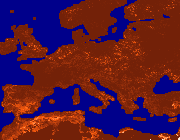

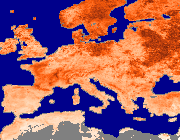

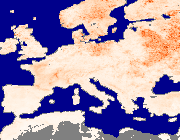

In [14]:
display(plotMAP(xout2,time=160,method=1))
display(plotMAP(xout2,time=160,method=2))
display(plotMAP(xout2,time=160,method=3))

In [23]:
meanscore=mapCube(timeMean,xout2)

Temporary Data Cube with the following dimensions
MethodAxis          Axis with elements: REC KDE KNN_Gamma 
longitude           Axis with 180 Elements from -10.0 to 34.75
latitude            Axis with 140 Elements from 65.0 to 30.25


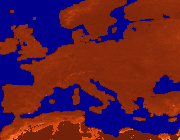

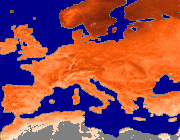

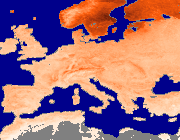

In [25]:
display(plotMAP(meanscore,method=1))
display(plotMAP(meanscore,method=2))
display(plotMAP(meanscore,method=3))

For all methods one can observe the effect of the global normalization. This leads to an overdetection of extremes in the zones where variablility of the underlying variables is highest. 